# Pretraining BERT

We will pretrain BERT on the WikiText-2 dataset in this section.


In [16]:
import torch
from torch import nn
import util
import model
import dataset
from timer import Timer
from animator import Animator
from accumulator import Accumulator

To start, we load the WikiText-2 dataset as minibatches
of pretraining examples for masked language modeling and next sentence prediction.
The batch size is 512 and the maximum length of a BERT input sequence is 64.
Note that in the original BERT model, the maximum length is 512.


In [17]:
batch_size, max_len = 512, 64
train_iter, vocab = util.load_csic_data(batch_size, max_len)

## Pretraining BERT

The original BERT has two versions of different model sizes :cite:`Devlin.Chang.Lee.ea.2018`.
The base model ($\textrm{BERT}_{\textrm{BASE}}$) uses 12 layers (Transformer encoder blocks)
with 768 hidden units (hidden size) and 12 self-attention heads.
The large model ($\textrm{BERT}_{\textrm{LARGE}}$) uses 24 layers
with 1024 hidden units and 16 self-attention heads.
Notably, the former has 110 million parameters while the latter has 340 million parameters.
For demonstration with ease,
we define [**a small BERT, using 2 layers, 128 hidden units, and 2 self-attention heads**].


In [18]:
net = model.BERTModel(len(vocab), num_hiddens=256,
                    ffn_num_hiddens=512, num_heads=2, num_blks=2, dropout=0.2)

devices = util.try_all_gpus()
loss = nn.CrossEntropyLoss()

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Before defining the training loop,
we define a helper function `_get_batch_loss_bert`.
Given the shard of training examples,
this function [**computes the loss for both the masked language modeling and next sentence prediction tasks**].
Note that the final loss of BERT pretraining
is just the sum of both the masked language modeling loss
and the next sentence prediction loss.


In [19]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

Invoking the two aforementioned helper functions,
the following `train_bert` function
defines the procedure to [**pretrain BERT (`net`) on the WikiText-2 (`train_iter`) dataset**].
Training BERT can take very long.
Instead of specifying the number of epochs for training
as in the `train_ch13` function (see :numref:`sec_image_augmentation`),
the input `num_steps` of the following function
specifies the number of iteration steps for training.


In [20]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net(*next(iter(train_iter))[:4])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, Timer()
    animator = Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

We can plot both the masked language modeling loss and the next sentence prediction loss
during BERT pretraining.


MLM loss 0.887, NSP loss 0.860
2354.0 sentence pairs/sec on [device(type='cuda', index=0)]


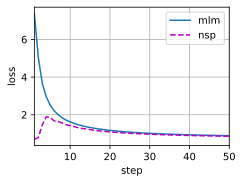

In [21]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

## [**Representing Text with BERT**]

After pretraining BERT,
we can use it to represent single text, text pairs, or any token in them.
The following function returns the BERT (`net`) representations for all tokens
in `tokens_a` and `tokens_b`.


In [22]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = dataset.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

[**Consider the sentence "a crane is flying".**]
Recall the input representation of BERT as discussed in :numref:`subsec_bert_input_rep`.
After inserting special tokens “&lt;cls&gt;” (used for classification)
and “&lt;sep&gt;” (used for separation),
the BERT input sequence has a length of six.
Since zero is the index of the “&lt;cls&gt;” token,
`encoded_text[:, 0, :]` is the BERT representation of the entire input sentence.
To evaluate the polysemy token "crane",
we also print out the first three elements of the BERT representation of the token.


In [23]:
tokens_a = ['id', '3', 'nombre', 'vino+rioja', 'precio', '100', 'cantidad', '55', 'b1', 'a%f1adir+al+carrito']
encoded_text = get_bert_encoding(net, tokens_a)
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 12, 256]),
 torch.Size([1, 256]),
 tensor([-2.3753, -0.1684, -2.6590], device='cuda:0', grad_fn=<SliceBackward0>))

In [24]:
import pickle

# Assuming 'model' is your machine learning model
# Fit the model on your data first (if it's not already trained)

# Save the model to a file
with open('sec-bert.pkl', 'wb') as file:
    pickle.dump(net, file)
